# Model/Pipeline Deployment
The objective of this notebook is to develop the final `predict.py` script that an end user would run to create cognitive fatigue predictions. The python version of this notebook is saved in `/src/predict_cf.py`

### Load packages

In [5]:
import pandas as pd
import pickle
import os

### Set global vars

In [13]:
PROJ_DIRECTORY = os.path.abspath(os.path.join(os.getcwd(), '..'))
DATA_DIRECTORY = os.path.join(PROJ_DIRECTORY, 'database')
OUTPUT_DIRECTORY = os.path.join(PROJ_DIRECTORY, 'outputs')
MODEL_DIRECTORY = os.path.join(PROJ_DIRECTORY, 'models')

### Read in data to be predicted - presaved since we don't have real world inputs

In a real-world scenario, we would expect to be receiving real-time eye tracking data that would be ingested directly into a database. This data would be queried into one "merged_df" into Python- which is a critical assumption of this deployed model. A graphic to visualize this is shown below.

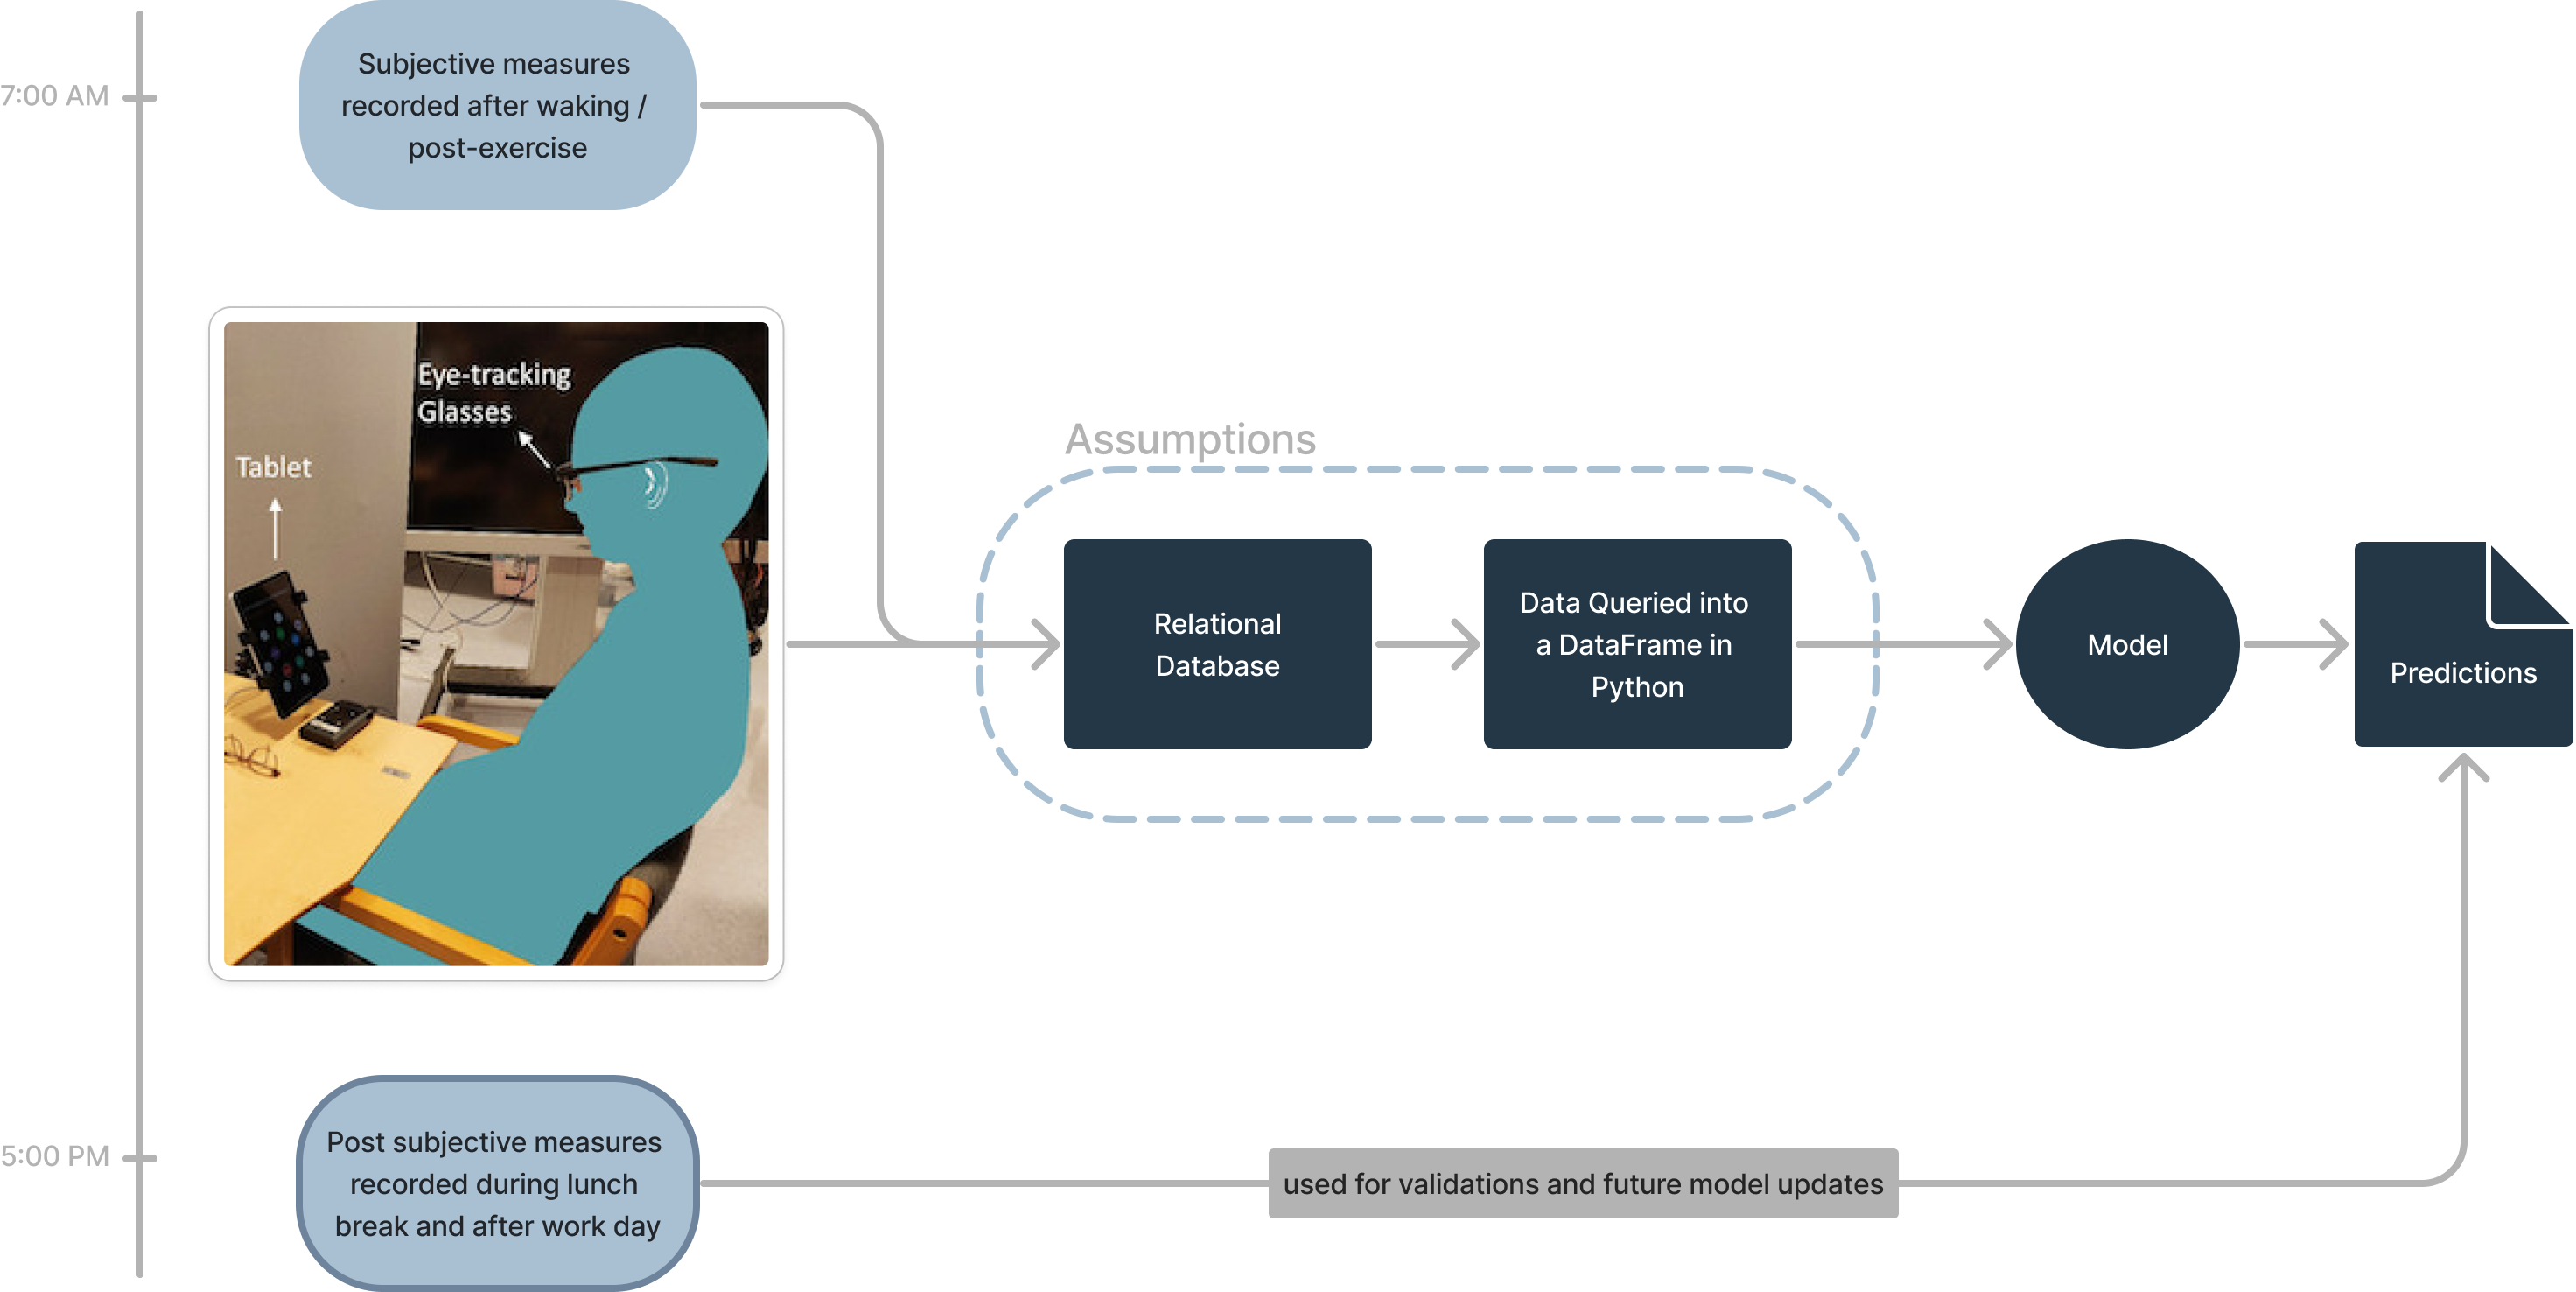

We also assume that "mentalFatigue" is an initialized column in the database that refers to the individuals subjective mental fatigue rating after work blocks. Will be Nan if the user has no historical data, otherwise it will be an int [1, 4].

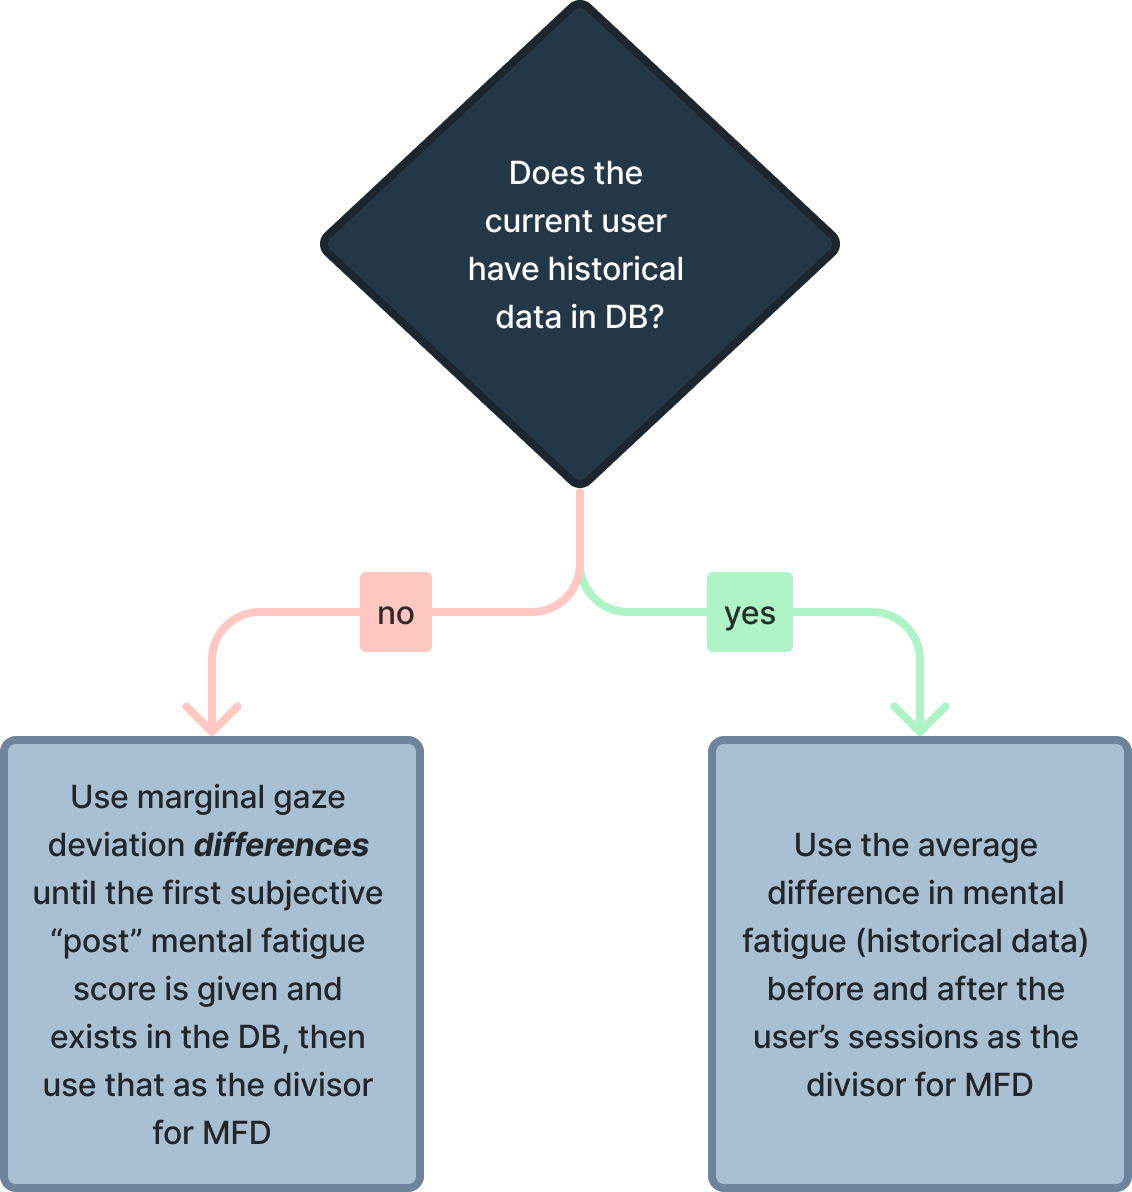

In [7]:
data = pd.read_csv(os.path.join(DATA_DIRECTORY, 'demo_data.csv'))

### Wrangle data

Here we would assume that data is queried into Python in an acceptable format

In [8]:
# remove trial parameters
data = data.drop(['subjectID', 'session', 'trial'], axis=1)

### Perform feature engineering - preprocessing will be done within pipeline

In [9]:
def get_mfd(final_df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates the mental fatigue derivative of the marginal gaze deviation with respect to change in mental fatigue (before and after).
    
    Args:
    final_df (pd.DataFrame): Merged, partially preprocessed DataFrame containing the columns 'gazeDeviation_marginal', 'mentalFatigue', and 'mentalFatigue_before'.
    
    Returns:
    pd.DataFrame: The DataFrame with an additional 'mental_derivative' column.
    """
    final_df['mental_derivative'] = None
    
    for j in range(0, final_df.shape[0] - 1, 2):
        if pd.isna(final_df['mentalFatigue'].iloc[j]) or (final_df['mentalFatigue'].iloc[j] - final_df['mentalFatigue_before'].iloc[j]) == 0: # results in a division by 0
            # if not change in mental fatigue then just take the difference
            final_df.loc[j, 'mental_derivative'] = (final_df['gazeDeviation_marginal'].iloc[j+1] - final_df['gazeDeviation_marginal'].iloc[j])
            final_df.loc[j+1, 'mental_derivative'] = (final_df['gazeDeviation_marginal'].iloc[j+1] - final_df['gazeDeviation_marginal'].iloc[j])
        else:
            # mental fatigue derivative calculation for the current and next row
            final_df.loc[j, 'mental_derivative'] = (final_df['gazeDeviation_marginal'].iloc[j+1] - final_df['gazeDeviation_marginal'].iloc[j]) / (final_df['mentalFatigue'].iloc[j] - final_df['mentalFatigue_before'].iloc[j])
            final_df.loc[j+1, 'mental_derivative'] = (final_df['gazeDeviation_marginal'].iloc[j+1] - final_df['gazeDeviation_marginal'].iloc[j]) / (final_df['mentalFatigue'].iloc[j+1] - final_df['mentalFatigue_before'].iloc[j+1])

    # eror catching in case the number of rows is odd in test split
    if final_df.shape[0] % 2 != 0:
        last_idx = final_df.shape[0] - 1
        if pd.isna(final_df['mentalFatigue'].iloc[j]) or (final_df['mentalFatigue'].iloc[last_idx] - final_df['mentalFatigue_before'].iloc[last_idx]) == 0:
            final_df.loc[last_idx, 'mental_derivative'] = (final_df['gazeDeviation_marginal'].iloc[last_idx] - final_df['gazeDeviation_marginal'].iloc[last_idx - 1])
        else:
            final_df.loc[last_idx, 'mental_derivative'] = (final_df['gazeDeviation_marginal'].iloc[last_idx] - final_df['gazeDeviation_marginal'].iloc[last_idx - 1]) / (final_df['mentalFatigue'].iloc[last_idx] - final_df['mentalFatigue_before'].iloc[last_idx])
    
    return final_df

In [10]:
# add mental fatigue derivative feature
get_mfd(data)

,sessionType,sessionTime,gazeDeviation_marginal,angular_velocity_gain,mentalFatigue_before,physicalFatigue_before,sleepiness_before,trialDifficultyLevel,gazeDeviation_complete,sleepScore,caffeineScore,alertnessScore,trialDuration,typingSpeed,correctedErrorRate,falseSelections,mentalFatigue,physicalFatigue,sleepiness,mental_derivative
0,MA,A,1.909002,0.893018,4,2,2,E,2.299013,1,3,4,445.403753,0.969907,11.764706,10.714286,NaN,2,2,0.439161
1,AM,M,2.348162,0.683889,1,1,1,D,2.232064,1,0,1,282.668579,1.188671,12.987013,12.727273,NaN,2,1,0.439161
2,AM,M,2.609825,1.030007,2,2,2,E,2.611977,1,0,1,350.425618,1.643715,12.162162,12.500000,NaN,2,3,-0.547566
3,MA,A,2.062260,0.891027,1,1,2,D,2.335875,-1,1,0,370.214408,1.328960,18.032787,20.634921,NaN,1,2,-0.547566
4,AM,A,2.710572,0.556105,3,2,3,D,3.010740,1,2,3,380.004010,1.168409,13.432836,11.267606,NaN,2,4,0.005476
5,MA,M,2.716048,0.891807,1,1,1,E,2.347766,1,3,4,427.533197,1.459536,13.095238,16.049383,NaN,2,2,0.005476
6,AM,M,2.054954,0.715905,1,1,1,D,2.069541,1,0,1,458.593479,1.334515,9.302326,24.705882,NaN,2,1,-0.262615
7,AM,A,1.792339,0.981731,1,2,1,E,1.856073,1,0,1,453.799687,1.375056,15.853659,19.718310,NaN,2,2,-0.262615
8,MA,M,2.898291,0.854306,2,2,2,D,3.364935,2,4,6,373.052926,0.868509,15.000000,21.153846,NaN,1,2,-0.063736
9,MA,M,2.834555,0.826605,3,4,4,D,2.367055,-1,3,2,271.753688,1.589675,8.333333,11.538462,NaN,4,4,-0.063736


In [11]:
def load_pipeline(pipeline_path):
    with open(pipeline_path, 'rb') as f:
        pipeline = pickle.load(f)
    return pipeline

def make_predictions(pipeline, data):
    # data = pd.read_csv(input_data_path)
    predictions = pipeline.predict(data)
    return predictions

In [14]:
pipeline_path = os.path.join(MODEL_DIRECTORY, 'cf_xgboost_pipeline.pkl')

best_pipeline = load_pipeline(pipeline_path)
preds = make_predictions(best_pipeline, data)

best_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical_transformer',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder())]),
                                                  ['sessionType', 'sessionTime',
                                                   'trialDifficultyLevel']),
                                                 ('numerical_transformer',
                                                  Pipeline(steps=[('rescale',
                                                                   StandardScaler())]),
                                                  ['angular_velocity_gain',
                                                   'mentalFatigue_before',
                                                   'physicalFatigue_be...
                               feature_types=None, gamma=0, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=300,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=30, ...))])

In [15]:
preds

array([1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0])

this model gave one false negative

---

## Creating the model dashboard

### 1. Create visualization of varying input subjective measures

Text(0.5, 1.0, 'Subjective Input Effects on Model Accuracy')

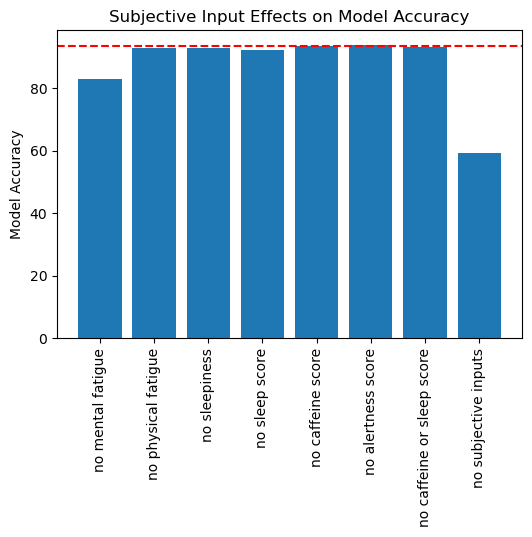

In [4]:
y = [82.75, 92.87, 92.63, 92.25, 93.50, 93.75, 93.16, 59.13]
X = ['no mental fatigue', 'no physical fatigue', 'no sleepiness', 'no sleep score', 'no caffeine score', 'no alertness score', 'no caffeine or sleep score', 'no subjective inputs']

import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.bar(X,y)
plt.axhline(93.5, color='red', linestyle = '--')
plt.xticks(rotation=90)
plt.ylabel('Model Accuracy')
plt.title('Subjective Input Effects on Model Accuracy')